In [1]:
!pip install category_encoders
import platform
import os
import sys
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 3.5 MB/s eta 0:00:00


In [2]:

display(platform.system())
file_download_link = 'https://data.ca.gov/dataset/3f08b68e-1d1a-4ba4-a07d-1ec3392ed191/resource/78a9d6ee-ec9a-4c25-ae34-5bac44010cb2/download/qcew_2016-2019.csv'
if os.name == 'nt':
    print(f'Please download your dataset here: {file_download_link}')
else:
    # If on another OS, use wget to download the CSV file directly
    !wget -O qcew_2016-2019.csv "$file_download_link" -o /dev/null
    print("File downloaded successfully as qcew_2016-2019.csv")
!{sys.executable} -m pip install imbalanced-learn delayed

'Linux'

File downloaded successfully as qcew_2016-2019.csv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 12.4 MB/s eta 0:00:00


In [4]:
# If using VSCode, don't run this cell
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Turn the dataset into a data frame
df = pd.read_csv('./qcew_2016-2019.csv')
print(f'The shape of the dataset is: {df.shape}')
df.head()

The shape of the dataset is: (1009955, 15)


,Area Type,Area Name,Year,Quarter,Ownership,NAICS Level,NAICS Code,Industry Name,Establishments,Average Monthly Employment,1st Month Emp,2nd Month Emp,3rd Month Emp,Total Wages (All Workers),Average Weekly Wages
0,County,Alameda County,2016,1st Qtr,Federal Government,2,1023,Financial Activities,1,10,10,10,10,359690.0,2767.0
1,County,Alameda County,2016,1st Qtr,Federal Government,2,1028,Public Administration,72,5174,5193,5143,5188,136068970.0,2023.0
2,County,Alameda County,2016,1st Qtr,Private,5,11121,Vegetable and Melon Farming,7,29,31,27,29,210934.0,560.0
3,County,Alameda County,2016,1st Qtr,Private,4,1114,Greenhouse and Nursery Production,7,52,61,64,31,748616.0,1107.0
4,County,Alameda County,2016,1st Qtr,Private,5,11142,Nursery and Floriculture Production,7,52,61,64,31,748616.0,1107.0


In [6]:
df['Area Type'].unique()

array(['County', 'California - Statewide', 'United States'], dtype=object)

In [7]:
df.columns

Index(['Area Type', 'Area Name', 'Year', 'Quarter', 'Ownership', 'NAICS Level',
       'NAICS Code', 'Industry Name', 'Establishments',
       'Average Monthly Employment', '1st Month Emp', '2nd Month Emp',
       '3rd Month Emp', 'Total Wages (All Workers)', 'Average Weekly Wages'],
      dtype='object')

In [8]:
df.describe()

,Year,NAICS Level,Establishments,Average Monthly Employment,1st Month Emp,2nd Month Emp,3rd Month Emp,Total Wages (All Workers),Average Weekly Wages
count,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06,1.009955e+06
mean,2.017506e+03,4.742008e+00,2.482561e+03,3.498097e+04,2.784764e+04,2.801089e+04,2.809293e+04,8.136866e+08,1.092761e+03
std,1.119452e+00,1.273100e+00,8.917906e+04,1.212335e+06,1.079614e+06,1.085457e+06,1.088328e+06,3.404081e+10,7.336131e+02
min,2.016000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.017000e+03,4.000000e+00,7.000000e+00,7.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.001182e+06,6.550000e+02
50%,2.018000e+03,5.000000e+00,2.000000e+01,3.030000e+02,1.490000e+02,1.500000e+02,1.490000e+02,4.946373e+06,9.560000e+02
75%,2.019000e+03,6.000000e+00,9.000000e+01,1.607000e+03,9.630000e+02,9.660000e+02,9.670000e+02,3.044671e+07,1.341000e+03
max,2.019000e+03,6.000000e+00,1.036382e+07,1.499311e+08,1.495277e+08,1.502603e+08,1.500053e+08,8.769109e+12,2.950200e+04


In [9]:
#Lots of data points, maybe we can drop the older years
print("Number of datapoints from 2018-2019: ", df.loc[df['Year'] == 2019].shape[0] + df.loc[df['Year'] == 2018].shape[0])

Number of datapoints from 2018-2019:  506913


In [10]:
#Checking what Area Types we have
print(f"Here are the area types we have: {df['Area Type'].unique().tolist()}")

Here are the area types we have: ['County', 'California - Statewide', 'United States']


In [11]:
#We want to focus on the county level, lets ensure there are enough datapoints to drop the rest
print("Number of datapoints that are just counties:", df.loc[(df['Area Type'] == 'County') & ((df['Year'] == 2019) | (df['Year'] == 2018))].shape[0])

Number of datapoints that are just counties: 441540


In [12]:
#Since there may be overlap between Quarters or the Annual datapoints, lets only use Annual, lets see if there are enough datapoints for that
print("Number of datapoints that are only Annual:", df.loc[(df['Area Type'] == 'County') & ((df['Year'] == 2019) | (df['Year'] == 2018)) & (df['Quarter'] == 'Annual')].shape[0])

Number of datapoints that are only Annual: 89255


In [13]:
#Lets see how many industry names there are, we may want to reduce this through economic sectors
#print(f"Here are all the industry names: {df['Industry Name'].unique().tolist()}")
print(f"Number of industry names: {df['Industry Name'].nunique()}")

Number of industry names: 1586


In [14]:
#Check for missing values
df.isnull().sum()

,0
Area Type,0
Area Name,0
Year,0
Quarter,0
Ownership,0
NAICS Level,0
NAICS Code,0
Industry Name,0
Establishments,0
Average Monthly Employment,0


In [15]:
#Drop some data points for faster visualization
dfTemp = df.loc[(df['Area Type'] == 'County') & ((df['Year'] == 2019) | (df['Year'] == 2018)) & (df['Quarter'] == 'Annual')]

In [16]:
# sns.pairplot(dfTemp)

In [17]:
#Drop categorical data
dfNonCategorical = dfTemp.copy(deep = True)
dfNonCategorical.drop(['1st Month Emp','2nd Month Emp','3rd Month Emp','Area Type','Area Name','Year','Quarter','Ownership','NAICS Level','NAICS Code','Industry Name'],axis=1,inplace=True)

<Axes: >

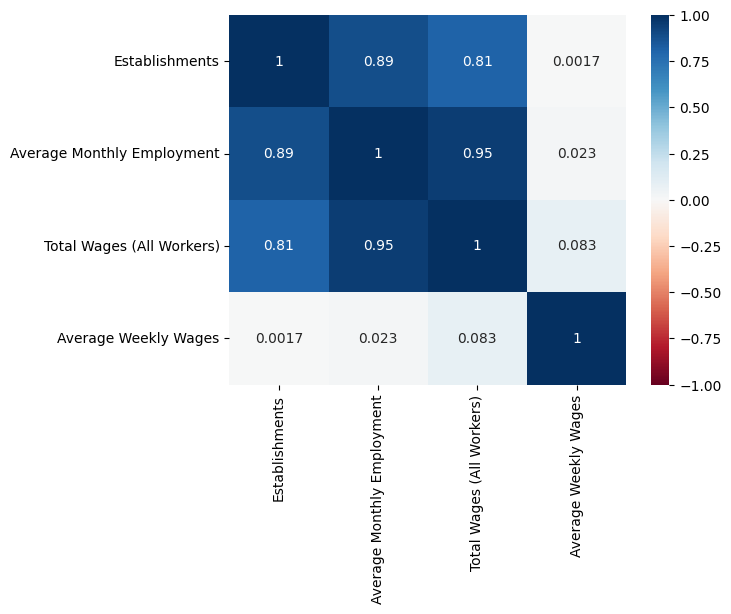

In [18]:
corr = dfNonCategorical.corr()
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, annot = True, cmap = 'RdBu')

In [19]:
for columnname in dfNonCategorical:
    print(columnname)
    print(shapiro(dfNonCategorical[columnname]))

Establishments
ShapiroResult(statistic=0.023661410219759094, pvalue=2.6148748874841756e-180)
Average Monthly Employment
ShapiroResult(statistic=0.036656412023569174, pvalue=7.648368176197863e-180)
Total Wages (All Workers)
ShapiroResult(statistic=0.03690291414377811, pvalue=7.806660267595417e-180)
Average Weekly Wages
ShapiroResult(statistic=0.7850183132652453, pvalue=1.6024122026725113e-131)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 89255.
  res = hypotest_fun_out(*samples, **kwds)


In [20]:
#Check data types of columns
df.dtypes

,0
Area Type,object
Area Name,object
Year,int64
Quarter,object
Ownership,object
NAICS Level,int64
NAICS Code,object
Industry Name,object
Establishments,int64
Average Monthly Employment,int64


In [21]:
#We don't need to know the total wages for all of the workers, who owns the business, or the individual months of employement
df.drop(['Ownership','1st Month Emp','2nd Month Emp','3rd Month Emp','Total Wages (All Workers)'],axis=1,inplace=True)
df.head()

,Area Type,Area Name,Year,Quarter,NAICS Level,NAICS Code,Industry Name,Establishments,Average Monthly Employment,Average Weekly Wages
0,County,Alameda County,2016,1st Qtr,2,1023,Financial Activities,1,10,2767.0
1,County,Alameda County,2016,1st Qtr,2,1028,Public Administration,72,5174,2023.0
2,County,Alameda County,2016,1st Qtr,5,11121,Vegetable and Melon Farming,7,29,560.0
3,County,Alameda County,2016,1st Qtr,4,1114,Greenhouse and Nursery Production,7,52,1107.0
4,County,Alameda County,2016,1st Qtr,5,11142,Nursery and Floriculture Production,7,52,1107.0


In [22]:
#We want to focus on the county level, lets ensure there are enough datapoints to drop the rest
df = df[df['Area Type'] == 'County']

In [23]:
#Since there may be overlap between Quarters or the Annual datapoints, lets only use Annual
df = df[df['Quarter'] == 'Annual']

In [24]:
#Now we can drop 'Area Type' and 'Quarter'
df.drop(['Area Type','Quarter'],axis=1,inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Area Name,Year,NAICS Level,NAICS Code,Industry Name,Establishments,Average Monthly Employment,Average Weekly Wages
0,Marin County,2019,6,441120,Used Car Dealers,6,46,1340.0
1,Marin County,2019,6,452210,Department Stores,10,819,666.0
2,Marin County,2019,6,561510,Travel Agencies,19,189,1065.0
3,Modoc County,2019,5,11331,Logging,4,19,1048.0
4,Modoc County,2019,6,113310,Logging,4,19,1048.0


In [25]:
#Drop older data points, more accurate since its newer data
df = df[df['Year'] != 2016]
df = df[df['Year'] != 2017]

In [26]:
df.shape

(89255, 8)

In [27]:
#Drop outliers using IQR
def dropOutliers(df, colName):
    [Q1, Q2, Q3] = df[colName].quantile([0.25, 0.5, 0.75])
    IQR = Q3 - Q1
    return df[(df[colName] >= (Q1 - (1.5 * IQR))) & (df[colName] <= (Q3 + (1.5 * IQR)))]
df = dropOutliers(df, 'Establishments')
df = dropOutliers(df, 'Average Monthly Employment')
df = dropOutliers(df, 'Average Weekly Wages')
print(df.shape)

(65689, 8)


In [28]:
#Too many industries, let's use NAICS code structure to generalize them into broader catgeories
sector_dict = {
    11 : "Agriculture, Forestry, Fishing and Hunting",
    21 : "Mining, Quarrying, and Oil and Gas Extraction",
    22 : "Utilities",
    23 : "Construction",
    31 : "Manufacturing",
    32 : "Manufacturing",
    33 : "Manufacturing",
    42 : "Wholesale Trade",
    44 : "Retail Trade",
    45 : "Retail Trade",
    48 : "Transportation and Warehousing",
    49 : "Transportation and Warehousing",
    51 : "Information",
    52 : "Finance and Insurance",
    53 : "Real Estate and Rental and Leasing",
    54 : "Professional, Scientific, and Technical Services",
    55 : "Management of Companies and Enterprises",
    56 : "Administrative and Support and Waste Management and Remediation Services",
    61 : "Educational Services",
    62 : "Health Care and Social Assistance",
    71 : "Arts, Entertainment, and Recreation",
    72 : "Accommodation and Food Services",
    81 : "Other Services (except Public Administration)",
    92 : "Public Administration",
    928110 : "Military",
}

def map_sector(row):
    # Check first for military code
    if row['NAICS Code'] == 928110:
        return sector_dict.get(928110)
    # Otherwise use sector dictionary ... otherwise use 'Industry Name'
    return sector_dict.get(int(str(row['NAICS Code'])[:2]), row['Industry Name'])

df['Sector'] = df.apply(map_sector, axis=1)
df.head()

,Area Name,Year,NAICS Level,NAICS Code,Industry Name,Establishments,Average Monthly Employment,Average Weekly Wages,Sector
0,Marin County,2019,6,441120,Used Car Dealers,6,46,1340.0,Retail Trade
1,Marin County,2019,6,452210,Department Stores,10,819,666.0,Retail Trade
2,Marin County,2019,6,561510,Travel Agencies,19,189,1065.0,Administrative and Support and Waste Managemen...
3,Modoc County,2019,5,11331,Logging,4,19,1048.0,"Agriculture, Forestry, Fishing and Hunting"
4,Modoc County,2019,6,113310,Logging,4,19,1048.0,"Agriculture, Forestry, Fishing and Hunting"


In [29]:
# map counties to their respective regions
county_to_region = {
    'Butte County': 'Superior',
    'Colusa County': 'Superior',
    'Del Norte County': 'Superior',
    'Glenn County': 'Superior',
    'Humboldt County': 'Superior',
    'Lake County': 'Superior',
    'Lassen County': 'Superior',
    'Mendocino County': 'Superior',
    'Modoc County': 'Superior',
    'Nevada County': 'Superior',
    'Plumas County': 'Superior',
    'Shasta County': 'Superior',
    'Sierra County': 'Superior',
    'Siskiyou County': 'Superior',
    'Tehama County': 'Superior',
    'Trinity County': 'Superior',
    'Alpine County': 'Central',
    'Amador County': 'Central',
    'Calaveras County': 'Central',
    'El Dorado County': 'Central',
    'Fresno County': 'Central',
    'Inyo County': 'Central',
    'Kings County': 'Central',
    'Madera County': 'Central',
    'Mariposa County': 'Central',
    'Merced County': 'Central',
    'Mono County': 'Central',
    'Placer County': 'Central',
    'Sacramento County': 'Central',
    'San Joaquin County': 'Central',
    'Stanislaus County': 'Central',
    'Sutter County': 'Central',
    'Yuba County': 'Central',
    'Tulare County': 'Central',
    'Tuolumne County': 'Central',
    'Yolo County': 'Central',
    'Alameda County': 'Bay Area',
    'Contra Costa County': 'Bay Area',
    'Marin County': 'Bay Area',
    'Monterey County': 'Bay Area',
    'Napa County': 'Bay Area',
    'San Benito County': 'Bay Area',
    'San Francisco County': 'Bay Area',
    'San Mateo County': 'Bay Area',
    'Santa Clara County': 'Bay Area',
    'Santa Cruz County': 'Bay Area',
    'Solano County': 'Bay Area',
    'Sonoma County': 'Bay Area',
    'Berkeley County': 'Bay Area',
    'Imperial County': 'Southern',
    'Kern County': 'Southern',
    'Orange County': 'Southern',
    'Riverside County': 'Southern',
    'San Bernardino County': 'Southern',
    'San Diego County': 'Southern',
    'San Luis Obispo County': 'Southern',
    'Santa Barbara County': 'Southern',
    'Ventura County': 'Southern',
    'Pomona County': 'Southern',
    'Claremont County': 'Southern',
    'La Verne County': 'Southern',
    'Los Angeles County': 'Southern'
}
df['Area Name'] = df['Area Name'].map(county_to_region)

In [30]:
#Since the NAICS code just represents the industry information, and we already derived the sectors from the codes, lets drop NAICS and Industry Name
df.drop(['NAICS Level','NAICS Code','Industry Name','Year'],axis=1,inplace=True)
df.head()

,Area Name,Establishments,Average Monthly Employment,Average Weekly Wages,Sector
0,Bay Area,6,46,1340.0,Retail Trade
1,Bay Area,10,819,666.0,Retail Trade
2,Bay Area,19,189,1065.0,Administrative and Support and Waste Managemen...
3,Superior,4,19,1048.0,"Agriculture, Forestry, Fishing and Hunting"
4,Superior,4,19,1048.0,"Agriculture, Forestry, Fishing and Hunting"


In [31]:
# One-hot-encode the 'Sector' feature
df_ohe = pd.get_dummies(df, columns=['Sector'], prefix='Sector', drop_first=True, dtype=int)

# Label encode the 'Sector' feature
df_label = df.copy()
df_label['Sector'] = df_label['Sector'].astype('category').cat.codes

# Drop the 'Sector' feature
df_nosector = df.drop(columns=['Sector'])

In [32]:
df_ohe.head()

,Area Name,Establishments,Average Monthly Employment,Average Weekly Wages,Sector_Administrative and Support and Waste Management and Remediation Services,"Sector_Agriculture, Forestry, Fishing and Hunting","Sector_Arts, Entertainment, and Recreation",Sector_Construction,Sector_Education and Health Services,Sector_Educational Services,...,Sector_Public Administration,Sector_Real Estate and Rental and Leasing,Sector_Retail Trade,Sector_Service-Providing,"Sector_Total, All Industries","Sector_Trade, Transportation, and Utilities",Sector_Transportation and Warehousing,Sector_Unclassified,Sector_Utilities,Sector_Wholesale Trade
0,Bay Area,6,46,1340.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Bay Area,10,819,666.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Bay Area,19,189,1065.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Superior,4,19,1048.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Superior,4,19,1048.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(df_label.drop(['Area Name'], axis=1), df_label['Area Name'], test_size=0.2, random_state=21)

In [34]:
#Standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [35]:
#Check the shapes
print(X_train.shape)
print(X_test.shape)
X_train.head()

(52551, 4)
(13138, 4)


,Establishments,Average Monthly Employment,Average Weekly Wages,Sector
0,-0.057241,0.312443,1.809918,-0.077735
1,1.428347,2.475806,0.500558,0.695946
2,0.154986,0.316286,-1.111975,0.806472
3,0.239877,0.020409,0.083145,-1.293519
4,-0.396804,-0.625142,-1.087809,-1.735623


In [36]:
#Trying out Decison Trees
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=40, min_samples_split=2, random_state=0)

In [37]:
#Perform cross-validation to estimate model performance
cv_scores = cross_val_score(clf_gini, X_train, y_train, cv=10)
print(f"Cross-validation accuracy: {cv_scores.mean()}")

Cross-validation accuracy: 0.7119750017016482


In [38]:
# Now fit the model to the full training data and obtain test accuracy
clf_gini.fit(X_train, y_train)

print('Testing accuracy:', accuracy_score(y_test, clf_gini.predict(X_test)))

Testing accuracy: 0.7351195006850357


In [39]:
# Initialize model
knn_clf = KNeighborsClassifier(n_neighbors=2, weights='distance')

# Fit model
knn_clf.fit(X_train, y_train)

cv_scores = cross_val_score(knn_clf, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print('Testing accuracy:', accuracy_score(y_test, knn_clf.predict(X_test)))

Cross-validation scores: [0.71658263 0.7130352  0.71427212 0.71084681 0.71588963]
Mean accuracy: 0.7141
Testing accuracy: 0.7598569036383012


In [52]:
from sklearn.metrics import confusion_matrix

# Get test predictions
y_pred = knn_clf.predict(X_test)

# get FP/FN values
cm = confusion_matrix(y_test, y_pred)

total_TP = 0
total_FP = 0
total_FN = 0
total_TN = 0
total_instances = cm.sum()

# Iterate through each class to calculate class-specific values
for i in range(cm.shape[0]):
    # Extract values for class i
    TN = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + cm[i, i]  # True Negatives
    FP = cm[:, i].sum() - cm[i, i]  # False Positives
    FN = cm[i, :].sum() - cm[i, i]  # False Negatives
    TP = cm[i, i]  # True Positives

    # Aggregate the totals
    total_TP += TP
    total_FP += FP
    total_FN += FN
    total_TN += TN

# Now calculate combined rates across all classes
total_TPR = total_TP / (total_TP + total_FN) if (total_TP + total_FN) != 0 else 0
total_TNR = total_TN / (total_TN + total_FP) if (total_TN + total_FP) != 0 else 0
total_FPR = total_FP / (total_TN + total_FP) if (total_TN + total_FP) != 0 else 0
total_FNR = total_FN / (total_FN + total_TP) if (total_FN + total_TP) != 0 else 0
accuracy = (total_TP + total_TN) / total_instances

# Print combined rates
print("Combined rates across all classes:")
print("Accuracy/Correct Rate:", accuracy)
print("True Positive Rate:", total_TPR)
print("True Negative Rate:", total_TNR)
print("False Positive Rate:", total_FPR)
print("False Negative Rate:", total_FNR)

Combined rates across all classes:
Accuracy/Correct Rate: 3.5197138072766023
True Positive Rate: 0.7598569036383012
True Negative Rate: 0.919952301212767
False Positive Rate: 0.08004769878723296
False Negative Rate: 0.2401430963616989
